In [2]:
from utils import pickle_load
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import pandas as pd
from evaluate import compute_sim, evaluate
from tqdm import tqdm

def l2norm(embs):
    return {k: v/np.linalg.norm(v, ord=2) for k, v in embs.items()}

def l2norm_numpy(x):
    return x / np.linalg.norm(x, ord=2, axis=1, keepdims=True)

infer_dir = 'D:'
infer_dir = '/Users/macbook/Downloads'
# infer_dir = 'C:/Users/msi/Downloads/drive-download-20220218T051534Z-001'

if os.path.exists('D:/whale_data/train_images-384-384/train_images-384-384'):
    train_img_dir = 'D:/whale_data/train_images-384-384/train_images-384-384'
else:
    train_img_dir = '/Users/macbook/works/train_images-384-384'


train_embs = pickle_load(f"{infer_dir}/train_embs.pkl")
test_embs = pickle_load(f"{infer_dir}/test_embs.pkl")
val_embs = pickle_load(f"{infer_dir}/val_embs.pkl")
train_df = pd.read_csv('data/train_kfold.csv')

train_embs = l2norm(train_embs)
test_embs = l2norm(test_embs)
val_embs = l2norm(val_embs)
# train_embs['00021adfb725ed.jpg']

In [3]:
class_count_df = train_df.groupby('individual_id').size().to_frame('count').reset_index()
class_count = dict(zip(class_count_df.individual_id, class_count_df['count']))

In [4]:
val_df = train_df[train_df.subset == 'test'].reset_index()

val_map = dict(zip(val_df.image, val_df.individual_id))
train_map = dict(zip(train_df.image, train_df.individual_id))
# val_imgs = val_df.image.unique()
# val_embs = {k: train_embs[k] for k in val_imgs}

In [5]:
from evaluate import compute_sim, evaluate, map_per_image, dict2list
from evaluate import *
from collections import Counter

def sum_score(topk):
    res = {}
    for id, score in topk:
        iid = train_map[id]
        res[iid] = res.get(iid, 0) + score

    res = sorted(res.items(), key=lambda kv: kv[1], reverse=True)
    return res

def compute_sim2(train_df, train_embs, test_embs):

    train_k, train_v = dict2list(train_embs)
    test_k, test_v = dict2list(test_embs)

    cos = np.dot(test_v, train_v.T)

    records = []
    topk = 100

    for i, scores in enumerate(tqdm(cos)):
        sort_idx = np.argsort(scores)[::-1]
        top5 = [[train_k[j], scores[j]] for j in sort_idx[:topk]]
        top5 = sum_score(top5)
        top5 = [x[0] for x in top5]

        for j in range(5):
            sim_score = scores[sort_idx[j]]
            if j == 1:#sim_score < 0.5:
                top5 = top5[:j] + ['new_individual'] + top5[j:4]
                break
            
        records.append([test_k[i], " ".join(top5)])

    sim_df = pd.DataFrame(records, columns=['image', 'predictions'])
    return sim_df

score, val_sim_df = evaluate(train_df, train_embs, val_embs)
val_sim_df["gt"] = val_sim_df.image.map(val_map)
val_sim_df["map"] = val_sim_df.apply(lambda row: map_per_image(row["gt"], row.predictions.split(" ")), axis=1)
val_sim_df = val_sim_df.sort_values("map")
val_sim_df["species"] = val_sim_df["image"].map(dict(zip(train_df.image, train_df.species)))
score

100%|██████████| 5710/5710 [00:05<00:00, 957.76it/s]


0.6473730297723292

In [6]:
train_k, train_v = dict2list(train_embs)
test_k, test_v = dict2list(val_embs)

cosines = np.matmul(test_v, train_v.T)

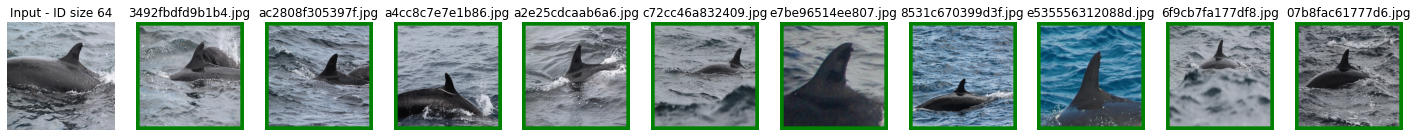

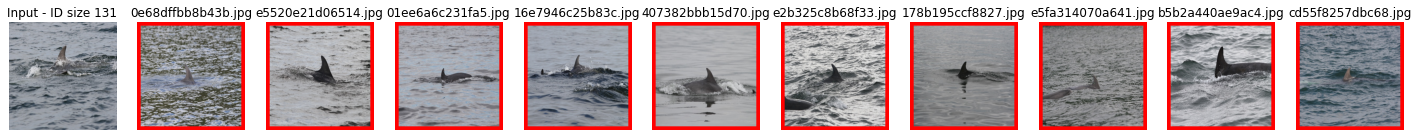

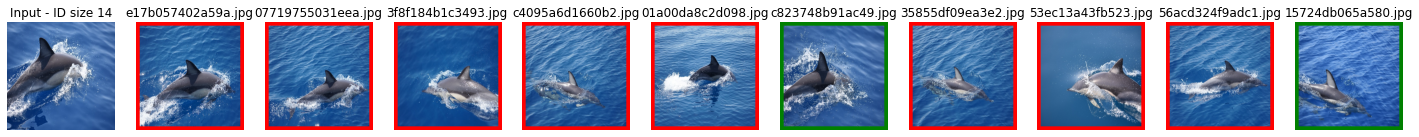

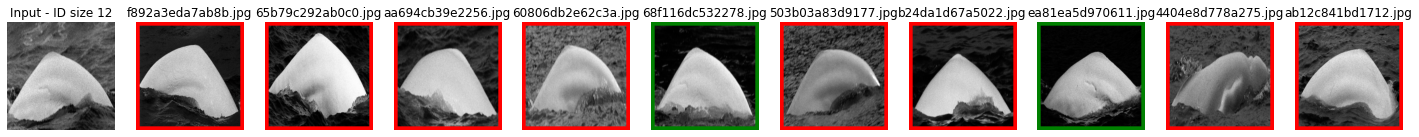

In [13]:
def add_border(img, color):
    bordersize = 14
    return cv2.copyMakeBorder(
        img,
        top=bordersize,
        bottom=bordersize,
        left=bordersize,
        right=bordersize,
        borderType=cv2.BORDER_CONSTANT,
        value=color
    )

c = 0
for i, scores in enumerate(cosines):
    if np.random.rand() < 0.5:
        sort_idx = np.argsort(scores)[::-1]
        topk = [train_k[j] for j in sort_idx[:10]]
        topk_id = [train_map[x] for x in topk]
        qid = test_k[i]
        gt = train_map[qid]
        c+=1
        imgs = [cv2.imread(f'{train_img_dir}/{qid}')[:,:,::-1]]
        for k, l in zip(topk, topk_id):
            im = cv2.imread(f'{train_img_dir}/{k}')[:,:,::-1]
            im = add_border(im, color=(255, 0, 0) if gt != l else (0, 128, 0))
            imgs.append(im)
        # Show image
        fig = plt.figure(figsize=(25, 4))
        columns = 11
        rows = 1
        for i2 in range(0, columns*rows):
            fig.add_subplot(rows, columns, i2+1)
            plt.title(f'Input - ID size {class_count[gt]}' if i2 == 0 else topk[i2 - 1])
            plt.imshow(imgs[i2])
            plt.axis('off')
        
        plt.show()
        
    if c == 4:
        break
    

In [21]:
train_df.query('image == "c823748b91ac49.jpg"')
# train_df.query('image == "e17b057402a59a.jpg"')

train_df.query('individual_id == "e943980b7a98"')

,image,species,individual_id,fold,sample_count,subset,label
30,002e00960cec44.jpg,common_dolphin,e943980b7a98,0,14,test,14228
1797,0938bb32569bed.jpg,common_dolphin,e943980b7a98,3,14,train,14228
1802,094073148d3961.jpg,common_dolphin,e943980b7a98,0,14,test,14228
4299,15724db065a580.jpg,common_dolphin,e943980b7a98,4,14,train,14228
9739,3105befed99617.jpg,common_dolphin,e943980b7a98,3,14,train,14228
10359,3413f5e8c63506.jpg,common_dolphin,e943980b7a98,3,14,train,14228
15230,4cea2572b4af1f.jpg,common_dolphin,e943980b7a98,2,14,train,14228
25512,80c86ca8ebe6ea.jpg,common_dolphin,e943980b7a98,0,14,test,14228
30817,9ae574e8f81e11.jpg,common_dolphin,e943980b7a98,0,14,test,14228
35152,b07cd4ea3d39fb.jpg,common_dolphin,e943980b7a98,4,14,train,14228


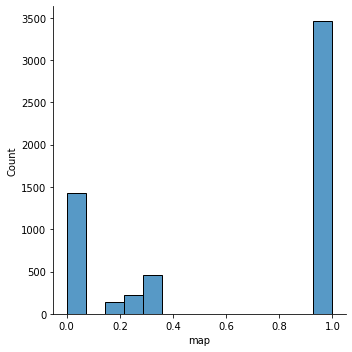

In [8]:
val_sim_df = val_sim_df.sort_values("map")
sns.displot(val_sim_df.map)

In [23]:
# val_sim_df
# raise
sim_df = compute_sim(train_df, {**train_embs, **val_embs}, test_embs)
sim_df[["image", "predictions"]].to_csv("submission.csv", index=False)
sim_df.head()

100%|██████████| 27956/27956 [00:33<00:00, 831.81it/s]


,image,predictions
0,ce385d0dcbbcb8.jpg,39fdf5369ae2 new_individual 127ddcc63b99 d20e4...
1,8d8d628d250300.jpg,10e758eb503a new_individual d673e4336f32 03c87...
2,e93cb01ed7f1a8.jpg,22c1eb2c8af4 new_individual 62ec6fea7ad5 a7a55...
3,8d548185675ac8.jpg,6a6fa3ec3810 new_individual 18efa8d0b472 938b7...
4,7fb5b1b21e7c89.jpg,9a66d006b36e new_individual 07a477b6a091 e9b12...


GT 3ca8fe39e601 0.0 killer_whale
165c0e1e349717.jpg


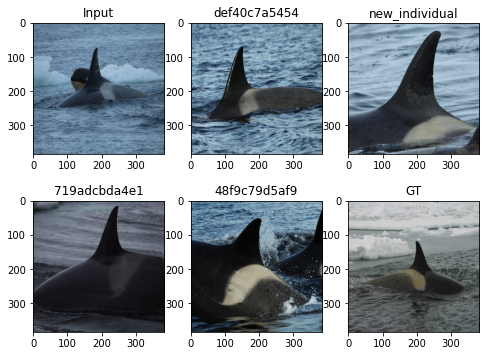

In [ ]:
def random_show(sim_df, is_val=False):
    sim_df = sim_df.copy()
    if is_val:
        sim_df = sim_df[sim_df["map"] == 0.0]
        sample = sim_df.iloc[np.random.choice(sim_df.index)]
        img1 = cv2.imread(f'{train_img_dir}/{sample.image}')[:, :, ::-1]
        print("GT", sample["gt"], sample["map"], sample["species"])
    else:
        sample = sim_df.iloc[np.random.choice(sim_df.index)]
        img1 = cv2.imread(f'D:/whale_data/test_images-384-384/test_images-384-384/{sample.image}')[:, :, ::-1]
        
    imgs = [img1]

    ids = sample.predictions.split(" ")
    for i in range(5):
        if ids[i] != 'new_individual':
            path = train_df[train_df.individual_id == ids[i]].values[0][0]
            img = cv2.imread(f'{train_img_dir}/{path}')[:, :, ::-1]
            imgs.append(img)

    if is_val:
        path = train_df[train_df.individual_id == sample["gt"]]["image"].values[0]
        print(path)
        img = cv2.imread(f'{train_img_dir}/{path}')[:, :, ::-1]
        imgs.append(img)

    fig = plt.figure(figsize=(8, 6))
    columns = 3
    rows = 2
    for i in range(0, columns*rows):
        fig.add_subplot(rows, columns, i+1)
        if i == 0:
            plt.title('Input')
        else:
            tt = ids[i-1]
            if i == 5:
                tt = 'GT'
            plt.title(tt)
        if i < len(imgs):
            
            plt.imshow(imgs[i])
    plt.show()

while True:
    try:
        random_show(val_sim_df, is_val=True)
        break
    except Exception as e:
        pass

# random_show(sim_df, is_val=False)

In [ ]:
from sklearn.cluster import DBSCAN

label2emb = defaultdict(list)
for label, d in train_df.groupby('individual_id'):
    for img_id in d.image.values:
        if img_id in train_embs:
            label2emb[label].append(train_embs[img_id])

for k, v in label2emb.items():
    if len(v) > 10:
        cluster = DBSCAN().fit(v)
        if len(np.unique(cluster.labels_)) > 1:
            print(k, cluster.labels_, len(v))

In [ ]:
# raise
from sklearn.neighbors import NearestNeighbors
knn = NearestNeighbors(n_neighbors=100,metric='cosine')

train_k, train_v = dict2list(train_embs)
test_k, test_v = dict2list(test_embs)
knn.fit(train_v)

NearestNeighbors(metric='cosine', n_neighbors=100)

In [ ]:
distances, idxs = knn.kneighbors(test_v, 100, return_distance=True)

In [ ]:
test_df = []
train_k = np.asarray(train_k)
img2id = dict(zip(train_df.image, train_df.individual_id))

for i in tqdm(range(len(test_k))):
    dist, idx = distances[i], idxs[i]
    for d, id in zip(dist, idx):
        img_id = train_k[id]
        tar = img2id[img_id]
        test_df.append([test_k[i], tar, d]) 
    

test_df = pd.DataFrame(test_df, columns=['image', 'target', 'distances'])
test_df['confidence'] = 1-test_df['distances']
test_df = test_df.groupby(['image','target']).confidence.max().reset_index()
test_df = test_df.sort_values('confidence',ascending=False).reset_index(drop=True)
test_df.to_csv('test_neighbors.csv')
test_df.image.value_counts().value_counts()

100%|██████████| 27956/27956 [00:06<00:00, 4262.82it/s]


81    453
84    431
83    427
80    417
74    415
     ... 
5      44
4      34
3      29
2      24
1      13
Name: image, Length: 100, dtype: int64

In [ ]:
sample_list = ['938b7e931166', '5bf17305f073', '7593d2aee842', '7362d7a01d00','956562ff2888']


In [ ]:
predictions = {}
for i,row in tqdm(test_df.iterrows(), total=len(test_df)):
    if row.image in predictions:
        if len(predictions[row.image])==5:
            continue
        predictions[row.image].append(row.target)
    elif row.confidence > 0.5:
        predictions[row.image] = [row.target,'new_individual']
    else:
        predictions[row.image] = ['new_individual',row.target]

for x in tqdm(predictions):
    if len(predictions[x])<5:
        remaining = [y for y in sample_list if y not in predictions]
        predictions[x] = predictions[x]+remaining
        predictions[x] = predictions[x][:5]
    predictions[x] = ' '.join(predictions[x])
    
predictions = pd.Series(predictions).reset_index()
predictions.columns = ['image','predictions']
predictions.to_csv('submission.csv',index=False)
predictions.head()

100%|██████████| 27956/27956 [00:00<00:00, 953804.55it/s]


,image,predictions
0,a3a9c424ef9f06.jpg,0ed88187dcb5 new_individual 46e4786e24c5 6164d...
1,5c9e04a6e6a9a2.jpg,547afd43d437 new_individual a752a6a6f645 9a3ee...
2,dd806b5d0f42e1.jpg,13e453fd9598 new_individual 74049e9bcf57 9395d...
3,3c52966f74d2ad.jpg,978520860ceb new_individual d4dfc9c0b367 50a48...
4,d846a86edded63.jpg,03a3bbaeed84 new_individual 75a8ca8be9c5 3dd9e...


In [ ]:
# sim_df = sim_df.sort_values('image')
# sim_df.to_csv('submission.csv', index=False)

# s655_df = pd.read_csv('submission_655.csv')
# s655_df= s655_df.sort_values('image')
# s655_df.to_csv('submission_655.csv', index=False)